<font color = blue><font size = 6> 모델설명 </font></font><br>
전체 데이터셋을 각 input sequence의 마지막 원소로 scaling(divide)을 한 이후각각의(seasonal,trend) Linear Layer를 통과시킨다 그 후 통과한 output값을 tanh activation function에 통과 시킨 다음 이를 score로 사용해서 각각의 output값에 다시 곱해준다음에 
이 score x output 값을 합친 이후 rescaling(multiplication) 해준다

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [79]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [80]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [81]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [82]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [83]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [84]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        div_factor = x.permute(0,2,1)[:,-1,:].view(-1,1,1)
        x = x/div_factor
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            seasonal_score,trend_score = self.activation(seasonal_output),self.activation(trend_output)
            
#             new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,1,2)
        #print(new_input)
        x = seasonal_output*seasonal_score + trend_output*trend_score
#         print(x.size())
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [85]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [86]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [87]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),6*1e-8)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [88]:
torch.manual_seed(42)

In [89]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [90]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
 
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 196.48041666599744 %
smape 186.35277392571433 %
smape 170.9091079723068 %
smape 153.15585373437892 %
smape 134.9715905301055 %
smape 117.3047609496535 %
smape 100.58044545134605 %
smape 84.97141919637981 %
smape 70.50726347499423 %
smape 57.183283692912056 %
smape 44.90124500634378 %
smape 33.61867939171038 %
smape 23.27399072242759 %
smape 13.767277657637123 %
smape 5.012444099792612 %
smape 0.6805754243685559 %
smape 0.6751075490243046 %
smape 0.6754100251784929 %
smape 0.6755212330897965 %
smape 0.6754268329503418 %
smape 0.6753083411416948 %
smape 0.6751225836461339 %
smape 0.6749599525597415 %
smape 0.6747719657073636 %
smape 0.6745837038254899 %
smape 0.6743881252423414 %
smape 0.6742158669628453 %
smape 0.6740289336827459 %
smape 0.6738529020439757 %
smape 0.673641573337495 %
smape 0.673438381413556 %
smape 0.6732745792247676 %
smape 0.6730653119715317 %
smape 0.6729097059864567 %
smape 0.6727020173215809 %
smape 0.6725327244671117 %
smape 0.6723428973386865 %
smape 0.6721

In [91]:
torch.manual_seed(42)

In [92]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [93]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)
torch.save(model,PATH+'/best_mymodel.pt') #모델의 갱신

SMAPE 0.05825854581053136 %
SMAPE 0.003198143464317127 %
SMAPE 0.006199327081390039 %
SMAPE 0.0020842516954644452 %
SMAPE 0.006058446197656053 %
SMAPE 0.002623471075622774 %
SMAPE 0.0018867717748207724 %
SMAPE 0.0020138259371833556 %
SMAPE 0.0019153951001058542 %
SMAPE 0.0016474493369145191 %
SMAPE 0.006055173886124976 %
SMAPE 0.011311172908882838 %
SMAPE 0.00517130645494035 %
SMAPE 0.0021375783294033113 %
SMAPE 0.003353649287419102 %
SMAPE 0.007535992669829739 %
SMAPE 0.003043183635270452 %
SMAPE 0.0030149324429089575 %
SMAPE 0.001768536701888479 %
SMAPE 0.0036604645583651063 %
SMAPE 0.004651788688192937 %
SMAPE 0.006325043622879888 %
SMAPE 0.008043328787849191 %
SMAPE 0.0031525245982493284 %
SMAPE 0.0016411368387139193 %
SMAPE 0.008484288407160534 %
SMAPE 0.000999782224653245 %
SMAPE 0.005503303585157937 %
SMAPE 0.0060292034682660756 %
SMAPE 0.006826269385072692 %
SMAPE 0.002217722504084918 %
SMAPE 0.004274173602368592 %
SMAPE 0.002114377603959383 %
SMAPE 0.001563977566604535 %
SMAPE

SMAPE 0.0021085899826402965 %
SMAPE 0.01087757565895231 %
SMAPE 0.019365691917435868 %
SMAPE 0.008318874945132393 %
SMAPE 0.008039317786014522 %
SMAPE 0.0046659684865062445 %
SMAPE 0.01892994742658516 %
SMAPE 0.008724917572358493 %
SMAPE 0.035166242558375416 %
SMAPE 0.0026751244803051577 %
SMAPE 0.003521773328067468 %
SMAPE 0.010820967545555504 %
SMAPE 0.009475999097006138 %
SMAPE 0.008104685051918636 %
SMAPE 0.0016265055375725979 %
SMAPE 0.002737547428353082 %
SMAPE 0.004625712662495118 %
SMAPE 0.005338363986822969 %
SMAPE 0.003958960326372107 %
SMAPE 0.0009793491633445228 %
SMAPE 0.0030846950368683683 %
SMAPE 0.0033801638203101447 %
SMAPE 0.0010425673229192967 %
SMAPE 0.0022102995052506458 %
SMAPE 0.005018127073498135 %
SMAPE 0.00256675478618007 %
SMAPE 0.001565917679897666 %
SMAPE 0.004314552461039511 %
SMAPE 0.0024374312581869617 %
SMAPE 0.010834858323676144 %
SMAPE 0.003166648148862805 %
SMAPE 0.002009707258508797 %
SMAPE 0.0025470195060393053 %
SMAPE 0.0027609773035237595 %
SMAPE

SMAPE 0.0011795201476729744 %
SMAPE 0.011825202644388355 %
SMAPE 0.006385098000755819 %
SMAPE 0.00788713307110811 %
SMAPE 0.001899725792270601 %
SMAPE 0.009869748718983828 %
SMAPE 0.002149278944756361 %
SMAPE 0.0026296025870351514 %
SMAPE 0.0024247792591722828 %
SMAPE 0.004608418448242446 %
SMAPE 0.005480920386503385 %
SMAPE 0.0036839852463970146 %
SMAPE 0.009270302808658926 %
SMAPE 0.0029819054669388834 %
SMAPE 0.0019257873313378582 %
SMAPE 0.008746148933767017 %
SMAPE 0.00273295810086438 %
SMAPE 0.019188239192573064 %
SMAPE 0.003602536136440904 %
SMAPE 0.0016839502020218333 %
SMAPE 0.0013821612561741858 %
SMAPE 0.0032076026267802153 %
SMAPE 0.007055690596651232 %
SMAPE 0.0034565861087685334 %
SMAPE 0.0023019858409725202 %
SMAPE 0.0019147217482213819 %
SMAPE 0.0009826896639424376 %
SMAPE 0.003310386052135073 %
SMAPE 0.007503313835456993 %
SMAPE 0.0016389474753850666 %
SMAPE 0.002454566657000612 %
SMAPE 0.002534857617661146 %
SMAPE 0.0028274703659008082 %
SMAPE 0.01274642170145768 %
SM

SMAPE 0.004886676558712111 %
SMAPE 0.01466204815037031 %
SMAPE 0.002295914654141029 %
SMAPE 0.001555587592832808 %
SMAPE 0.00953691276419022 %
SMAPE 0.008568384838582688 %
SMAPE 0.01221127092117058 %
SMAPE 0.002772066856920219 %
SMAPE 0.010738679181315547 %
SMAPE 0.001382236341044063 %
SMAPE 0.0017573432346011941 %
SMAPE 0.027908946717730032 %
SMAPE 0.0078100350647218875 %
SMAPE 0.01765310720531943 %
SMAPE 0.0038744194799846805 %
SMAPE 0.0032413119479244305 %
SMAPE 0.008880350225979328 %
SMAPE 0.002197409224223179 %
SMAPE 0.001639704706022371 %
SMAPE 0.001549463981334043 %
SMAPE 0.0010068340790070351 %
SMAPE 0.007515395721583218 %
SMAPE 0.00146056610824985 %
SMAPE 0.00381726114071057 %
SMAPE 0.0016003411292757619 %
SMAPE 0.003252992875559357 %
SMAPE 0.005340050516821293 %
SMAPE 0.004661816313657141 %
SMAPE 0.003631584038203073 %
SMAPE 0.007458775451482325 %
SMAPE 0.0009783725677152688 %
SMAPE 0.003559292414315962 %
SMAPE 0.0028751529626447336 %
SMAPE 0.0012484509838941449 %
SMAPE 0.004

SMAPE 0.0064936388299656755 %
SMAPE 0.03856061306865399 %
SMAPE 0.009120128775009562 %
SMAPE 0.01699121254733882 %
SMAPE 0.007746833062043379 %
SMAPE 0.0029542692076773847 %
SMAPE 0.011391994215159684 %
SMAPE 0.005258572167832654 %
SMAPE 0.004887803912566824 %
SMAPE 0.002746088576088823 %
SMAPE 0.0030215666779156436 %
SMAPE 0.005523540274779748 %
SMAPE 0.004034469337625524 %
SMAPE 0.003438010675267833 %
SMAPE 0.0051237443214233735 %
SMAPE 0.001515511047017526 %
SMAPE 0.002569673785046689 %
SMAPE 0.0019613447916952964 %
SMAPE 0.00338441776051468 %
SMAPE 0.006303032455434732 %
SMAPE 0.013376855180794678 %
SMAPE 0.003011111881846773 %
SMAPE 0.00029493944714431564 %
SMAPE 0.0048918641826958265 %
SMAPE 0.004141848927559977 %
SMAPE 0.004891966968216366 %
SMAPE 0.003885615956733091 %
SMAPE 0.009737463544688296 %
SMAPE 0.002985026284051173 %
SMAPE 0.0032578039367763267 %
SMAPE 0.003622771752731069 %
SMAPE 0.002937243133146694 %
SMAPE 0.003328141601059542 %
SMAPE 0.007483619444656142 %
SMAPE 0.

SMAPE 0.0031989646538477245 %
SMAPE 0.0081065689244042 %
SMAPE 0.0005317984032444656 %
SMAPE 0.007520286065300752 %
SMAPE 0.004957427650964519 %
SMAPE 0.004657182594876019 %
SMAPE 0.002425103796241501 %
SMAPE 0.005373098464360737 %
SMAPE 0.0027525884453254434 %
SMAPE 0.0034215693764707567 %
SMAPE 0.0006902650082594164 %
SMAPE 0.0017100977260327 %
SMAPE 0.0021632481247593205 %
SMAPE 0.001402919892413479 %
SMAPE 0.0042119997508791585 %
SMAPE 0.009871332552066292 %
SMAPE 0.001406314366619199 %
SMAPE 0.000887697272091259 %
SMAPE 0.000556071270693792 %
SMAPE 0.00538666100572982 %
SMAPE 0.0044921885141206985 %
SMAPE 0.00106679371988605 %
SMAPE 0.0010505372243869715 %
SMAPE 0.01094593312572556 %
SMAPE 0.0044783510516595015 %
SMAPE 0.0020976257111300356 %
SMAPE 0.00882843825345958 %
SMAPE 0.005940272880025077 %
SMAPE 0.0027436334355854797 %
SMAPE 0.002905261800833614 %
SMAPE 0.00222868057004888 %
SMAPE 0.0021045188613086907 %
SMAPE 0.0024128954360094212 %
SMAPE 0.0022495527783235048 %
SMAPE 0.

SMAPE 0.0008595116507308375 %
SMAPE 0.005272660352545699 %
SMAPE 0.002545957638865559 %
SMAPE 0.0014557597476141382 %
SMAPE 0.0032283399619359443 %
SMAPE 0.005340961061463645 %
SMAPE 0.006092182109000532 %
SMAPE 0.0011751260652772544 %
SMAPE 0.006091469087920132 %
SMAPE 0.0014129696896816313 %
SMAPE 0.006091813988177819 %
SMAPE 0.005380429215946947 %
SMAPE 0.0028403305559265846 %
SMAPE 0.0026444618278560483 %
SMAPE 0.0011351150626808248 %
SMAPE 0.006575434363071509 %
SMAPE 0.0033647714543576512 %
SMAPE 0.004051208918838256 %
SMAPE 0.002565035496111534 %
SMAPE 0.002389700901176184 %
SMAPE 0.0042231585739784805 %
SMAPE 0.0021439961869873514 %
SMAPE 0.00902903944763267 %
SMAPE 0.0031562194155299035 %
SMAPE 0.0014150140889341856 %
SMAPE 0.008923993466574132 %
SMAPE 0.006011367610540219 %
SMAPE 0.0028422909968170984 %
SMAPE 0.003615697621420111 %
SMAPE 0.0034174949232124168 %
SMAPE 0.0037177165775119643 %
SMAPE 0.004341247170827955 %
SMAPE 0.0024184192916436587 %
SMAPE 0.007401952444865856 

SMAPE 0.0030284572197558646 %
SMAPE 0.0018174785065809829 %
SMAPE 0.002194892960261541 %
SMAPE 0.0053655092293922735 %
SMAPE 0.0028695865581767066 %
SMAPE 0.007502645455815581 %
SMAPE 0.0024879336517642514 %
SMAPE 0.003226197769436112 %
SMAPE 0.005452903928159003 %
SMAPE 0.0067609283594123335 %
SMAPE 0.004960722177344223 %
SMAPE 0.0029848421343103837 %
SMAPE 0.001666352930030257 %
SMAPE 0.00432559915816455 %
SMAPE 0.0021265078971879348 %
SMAPE 0.0012739676304818204 %
SMAPE 0.0033252758585717856 %
SMAPE 0.0010502328519521598 %
SMAPE 0.007452495945415194 %
SMAPE 0.003349145210997051 %
SMAPE 0.00330690812639034 %
SMAPE 0.010004096405964447 %
SMAPE 0.011446122141364867 %
SMAPE 0.01246994571107507 %
SMAPE 0.005724397749759191 %
SMAPE 0.005661219326327682 %
SMAPE 0.004432935972346286 %
SMAPE 0.0044291144258892245 %
SMAPE 0.010130025511543295 %
SMAPE 0.0014215847689911243 %
SMAPE 0.0023988994358887794 %
SMAPE 0.0026768397075045414 %
SMAPE 0.00227409871808959 %
SMAPE 0.0019365696167881197 %
SM

SMAPE 0.0035904659424659258 %
SMAPE 0.0020771814123463628 %
SMAPE 0.0014454271938291186 %
SMAPE 0.003384451111827502 %
SMAPE 0.0028834036830858167 %
SMAPE 0.002364358537164435 %
SMAPE 0.002794269812739003 %
SMAPE 0.011991988323515557 %
SMAPE 0.00165008699772784 %
SMAPE 0.0031998690809871277 %
SMAPE 0.001024831110356672 %
SMAPE 0.0074955172522663815 %
SMAPE 0.007701022138917324 %
SMAPE 0.003586897384195708 %
SMAPE 0.0011697268256227744 %
SMAPE 0.003194064434353549 %
SMAPE 0.002939761616630676 %
SMAPE 0.008424134544043227 %
SMAPE 0.0016033012818752468 %
SMAPE 0.002352902037955573 %
SMAPE 0.002282312778930873 %
SMAPE 0.005377665236210305 %
SMAPE 0.005080521842415919 %
SMAPE 0.0011218994521300374 %
SMAPE 0.0026192829946225515 %
SMAPE 0.003225212789999432 %
SMAPE 0.007804385865057385 %
SMAPE 0.003233298244964544 %
SMAPE 0.0024012089051268504 %
SMAPE 0.009164734837597166 %
SMAPE 0.006403000451911112 %
SMAPE 0.0011052592907532244 %
SMAPE 0.004281201142759983 %
SMAPE 0.0011481572798004436 %
SM

SMAPE 0.004340193611085397 %
SMAPE 0.0021826879912794084 %
SMAPE 0.004933269487722214 %
SMAPE 0.001996229100612368 %
SMAPE 0.005391257158684937 %
SMAPE 0.001704573688328992 %
SMAPE 0.009884535252780324 %
SMAPE 0.0036458644539152374 %
SMAPE 0.007514611992071708 %
SMAPE 0.0009253459823810317 %
SMAPE 0.004720141141518752 %
SMAPE 0.00378661912827738 %
SMAPE 0.002212299872368817 %
SMAPE 0.0018554548107516664 %
SMAPE 0.005043233630658506 %
SMAPE 0.01073176450580604 %
SMAPE 0.0032676308028385397 %
SMAPE 0.004851918193082838 %
SMAPE 0.001757208420826828 %
SMAPE 0.00803428531736472 %
SMAPE 0.004823255689046846 %
SMAPE 0.006215804748961773 %
SMAPE 0.0013663778564563245 %
SMAPE 0.0024053030044299817 %
SMAPE 0.010032389870673342 %
SMAPE 0.007739864143928799 %
SMAPE 0.0016423900469817454 %
SMAPE 0.004646001425442137 %
SMAPE 0.007249739207367156 %
SMAPE 0.00636516187753955 %
SMAPE 0.005593973412224784 %
SMAPE 0.002072173643341557 %
SMAPE 0.005071269348519536 %
SMAPE 0.017570255166823756 %
SMAPE 0.00

SMAPE 0.002102560735181669 %
SMAPE 0.0016799686204151956 %
SMAPE 0.0012821655122863262 %
SMAPE 0.0018467017749230763 %
SMAPE 0.005245457370619988 %
SMAPE 0.004233944756833807 %
SMAPE 0.005676381740215675 %
SMAPE 0.0025860881079324827 %
SMAPE 0.0036009687597129414 %
SMAPE 0.009759005246763763 %
SMAPE 0.0023033375259018385 %
SMAPE 0.0035361528321828928 %
SMAPE 0.002242604941045556 %
SMAPE 0.0014772400679419206 %
SMAPE 0.0014318875439869316 %
SMAPE 0.003394877796310425 %
SMAPE 0.007708211498538731 %
SMAPE 0.004878662454643745 %
SMAPE 0.0009717594290776787 %
SMAPE 0.0017060798690806678 %
SMAPE 0.007046622653987811 %
SMAPE 0.004157784217525773 %
SMAPE 0.0057840052458573155 %
SMAPE 0.003062461105798775 %
SMAPE 0.003274789922372179 %
SMAPE 0.004685461272593727 %
SMAPE 0.0009758042081102758 %
SMAPE 0.0037784186660587693 %
SMAPE 0.005704360639541051 %
SMAPE 0.002390630154422979 %
SMAPE 0.005517964814316656 %
SMAPE 0.003395101303794945 %
SMAPE 0.0049016310160823195 %
SMAPE 0.005593180586195956 %

SMAPE 0.022050576666913457 %
SMAPE 0.01712275305953881 %
SMAPE 0.030959065728808355 %
SMAPE 0.01014571206957271 %
SMAPE 0.002771576699757361 %
SMAPE 0.01669583855846213 %
SMAPE 0.007573940384069999 %
SMAPE 0.008135602942388687 %
SMAPE 0.005447922995749366 %
SMAPE 0.010101785841868605 %
SMAPE 0.006906162235779333 %
SMAPE 0.004892428017399197 %
SMAPE 0.007356076024819913 %
SMAPE 0.011093995596425543 %
SMAPE 0.002179267033227461 %
SMAPE 0.00935441562342021 %
SMAPE 0.0019239851560541865 %
SMAPE 0.005114965865203658 %
SMAPE 0.007186719585320134 %
SMAPE 0.005241868849310549 %
SMAPE 0.00871641874158513 %
SMAPE 0.004046902108939321 %
SMAPE 0.012055176309445415 %
SMAPE 0.003803794031597363 %
SMAPE 0.004283165714099368 %
SMAPE 0.0084545673652201 %
SMAPE 0.002551734264272909 %
SMAPE 0.005031210045245871 %
SMAPE 0.00261825028843532 %
SMAPE 0.0045968746771336555 %
SMAPE 0.010939720840028144 %
SMAPE 0.01043395777026035 %
SMAPE 0.0018513743707444519 %
SMAPE 0.007643140648440294 %
SMAPE 0.011253681584

SMAPE 0.009024275202513365 %
SMAPE 0.0144338246244331 %
SMAPE 0.007239613410661149 %
SMAPE 0.003551887192145386 %
SMAPE 0.02352767292398994 %
SMAPE 0.0137491691897651 %
SMAPE 0.005730425091826419 %
SMAPE 0.0017494141413862963 %
SMAPE 0.0026902265785793134 %
SMAPE 0.012705217549864754 %
SMAPE 0.006673471808468889 %
SMAPE 0.0016519705487212377 %
SMAPE 0.0100039043994542 %
SMAPE 0.005132119083583575 %
SMAPE 0.010290208758817698 %
SMAPE 0.0036568209615097658 %
SMAPE 0.006709644980446684 %
SMAPE 0.0035987091897595747 %
SMAPE 0.015289473146708586 %
SMAPE 0.0009021969700597765 %
SMAPE 0.0014457665839699985 %
SMAPE 0.0022115447522566 %
SMAPE 0.009793725436168188 %
SMAPE 0.0032441057869618817 %
SMAPE 0.0051411749509497895 %
SMAPE 0.005664162440666587 %
SMAPE 0.004181493317908291 %
SMAPE 0.003455447709427517 %
SMAPE 0.006110859869323804 %
SMAPE 0.020567869619583234 %
SMAPE 0.013583399380650006 %
SMAPE 0.003576605473341488 %
SMAPE 0.002194032602773177 %
SMAPE 0.021425632943717687 %
SMAPE 0.014978

SMAPE 0.008229499941080576 %
SMAPE 0.006442219804000615 %
SMAPE 0.001840063673171244 %
SMAPE 0.007508912994126148 %
SMAPE 0.0017054054521281614 %
SMAPE 0.010675747715595207 %
SMAPE 0.0017821805291760027 %
SMAPE 0.001140586201302085 %
SMAPE 0.0030560592301753786 %
SMAPE 0.0056779306825092135 %
SMAPE 0.006915090745678753 %
SMAPE 0.0021671758484842485 %
SMAPE 0.006280665245355976 %
SMAPE 0.013440006425440743 %
SMAPE 0.004439817973945992 %
SMAPE 0.01107918012189657 %
SMAPE 0.0034083340900679104 %
SMAPE 0.0008898137849939758 %
SMAPE 0.011389645369803247 %
SMAPE 0.00254780077889194 %
SMAPE 0.007265380625540274 %
SMAPE 0.005796057997144999 %
SMAPE 0.003142406510292517 %
SMAPE 0.007016666591084686 %
SMAPE 0.008394067707172326 %
SMAPE 0.0036555087498300054 %
SMAPE 0.010930784948122607 %
SMAPE 0.0027851327085954836 %
SMAPE 0.0021882552262013633 %
SMAPE 0.004712229632389153 %
SMAPE 0.0027413053144300648 %
SMAPE 0.0012222015006884135 %
SMAPE 0.023477603004778302 %
SMAPE 0.0019403621322169329 %
SMA

SMAPE 0.012272215393608121 %
SMAPE 0.016183456308908717 %
SMAPE 0.019595752800910304 %
SMAPE 0.00802249197636229 %
SMAPE 0.004796411711794235 %
SMAPE 0.014366931739601796 %
SMAPE 0.002743690674606114 %
SMAPE 0.0017651885546428048 %
SMAPE 0.0023168992658213483 %
SMAPE 0.008414415613685833 %
SMAPE 0.01444124222314258 %
SMAPE 0.005107767204535207 %
SMAPE 0.01165517536311711 %
SMAPE 0.0018502922828815827 %
SMAPE 0.010278598370405234 %
SMAPE 0.003878581432218198 %
SMAPE 0.011706834370997399 %
SMAPE 0.006587245942384357 %
SMAPE 0.0034566554723483023 %
SMAPE 0.003938844716003587 %
SMAPE 0.0015081451263796453 %
SMAPE 0.010287509727959332 %
SMAPE 0.00953894963726043 %
SMAPE 0.0010456869236108446 %
SMAPE 0.006701754978323037 %
SMAPE 0.006079096044324217 %
SMAPE 0.012497139323528472 %
SMAPE 0.012831804270859948 %
SMAPE 0.013575857973364693 %
SMAPE 0.007631792981641183 %
SMAPE 0.005897778886705396 %
SMAPE 0.005838536258664817 %
SMAPE 0.013569714992996751 %
SMAPE 0.0056990906277434306 %
SMAPE 0.001

SMAPE 0.00841795034102688 %
SMAPE 0.004363037923781121 %
SMAPE 0.00872031179326882 %
SMAPE 0.01048156242791265 %
SMAPE 0.01721113839357713 %
SMAPE 0.021645201401440772 %
SMAPE 0.0021639172508827187 %
SMAPE 0.00806471160694855 %
SMAPE 0.01953328831075396 %
SMAPE 0.004623110362445004 %
SMAPE 0.0019130892772238897 %
SMAPE 0.003988898940946228 %
SMAPE 0.0033309715101950133 %
SMAPE 0.021499867044575183 %
SMAPE 0.010877735299004598 %
SMAPE 0.002329600711391322 %
SMAPE 0.00659109744685793 %
SMAPE 0.00385530966582337 %
SMAPE 0.01970912343949749 %
SMAPE 0.013802263306899931 %
SMAPE 0.014849165725394187 %
SMAPE 0.01395985045968473 %
SMAPE 0.010278333730092015 %
SMAPE 0.004141734359230043 %
SMAPE 0.0019904986098708832 %
SMAPE 0.010469319456717585 %
SMAPE 0.0052010064431442515 %
SMAPE 0.002176594192761172 %
SMAPE 0.0009641938392661586 %
SMAPE 0.008177387200674957 %
SMAPE 0.00791217866499494 %
SMAPE 0.0030240938245924553 %
SMAPE 0.0020210628802956876 %
SMAPE 0.006347985506636179 %
SMAPE 0.001119688

SMAPE 0.004700645826005712 %
SMAPE 0.0017819186473388984 %
SMAPE 0.005713731617447593 %
SMAPE 0.009145652325457831 %
SMAPE 0.0016954676229943288 %
SMAPE 0.004047922039717378 %
SMAPE 0.0022338745197032495 %
SMAPE 0.0029848654542092845 %
SMAPE 0.006106328106923797 %
SMAPE 0.005842384011060631 %
SMAPE 0.0030707683131367958 %
SMAPE 0.00205584617549448 %
SMAPE 0.0022383264836207672 %
SMAPE 0.0069098081175695825 %
SMAPE 0.009418339300395928 %
SMAPE 0.02197542915507711 %
SMAPE 0.02713051910603781 %
SMAPE 0.020743243702526115 %
SMAPE 0.0023096539896627633 %
SMAPE 0.0061682935495355196 %
SMAPE 0.005167748913265768 %
SMAPE 0.004317910696997274 %
SMAPE 0.0053700145863047055 %
SMAPE 0.011058007049427943 %
SMAPE 0.006491390979633138 %
SMAPE 0.005685569597730478 %
SMAPE 0.006124275726676842 %
SMAPE 0.005014588090652694 %
SMAPE 0.0037650427420317105 %
SMAPE 0.006816138321305232 %
SMAPE 0.0018860369214053208 %
SMAPE 0.002494425864540517 %
SMAPE 0.0034070013147200484 %
SMAPE 0.0017192546743274306 %
SMA

SMAPE 0.07357402392670309 %
SMAPE 0.030423931807121107 %
SMAPE 0.008882380583600025 %
SMAPE 0.027933521274349005 %
SMAPE 0.010086265287043261 %
SMAPE 0.0033818542732149126 %
SMAPE 0.14352495562081913 %
SMAPE 0.01207494040276913 %
SMAPE 0.027945183831697307 %
SMAPE 0.025630271023828755 %
SMAPE 0.014748268768755679 %
SMAPE 0.02127230373139355 %
SMAPE 0.13067108781660863 %
SMAPE 0.0062308471077727745 %
SMAPE 0.03115353245118513 %
SMAPE 0.011448809614876154 %
SMAPE 0.002851377427788293 %
SMAPE 0.03494477955018738 %
SMAPE 0.13115850036547272 %
SMAPE 0.027876851605327598 %
SMAPE 0.016177342921764648 %
SMAPE 0.03441429884748004 %
SMAPE 0.009462881219519659 %
SMAPE 0.0284207237794476 %
SMAPE 0.009477671077377181 %
SMAPE 0.020738759315918287 %
SMAPE 0.007372704451626078 %
SMAPE 0.005724896758287912 %
SMAPE 0.03291075676531818 %
SMAPE 0.12156874876700385 %
SMAPE 0.03259362381375297 %
SMAPE 0.03271142321318621 %
SMAPE 0.005640478011628147 %
SMAPE 0.004068271475262009 %
SMAPE 0.011479641686371167 

SMAPE 0.8647134492639452 %
SMAPE 0.3292708023868727 %
SMAPE 0.04025995135918947 %
SMAPE 0.5104176203312818 %
SMAPE 0.013201401909782362 %
SMAPE 0.08114027883061681 %
SMAPE 0.059945084263119945 %
SMAPE 0.07236171256465695 %
SMAPE 0.09542975580598068 %
SMAPE 0.32553648432076443 %
SMAPE 0.028833483108428485 %
SMAPE 0.34462863066164573 %
SMAPE 1.6246210280805826 %
SMAPE 0.011081480087227646 %
SMAPE 0.3583983044445631 %
SMAPE 0.003041719093154427 %
SMAPE 0.22160432002783637 %
SMAPE 0.484739959523722 %
SMAPE 0.8582031053956598 %
SMAPE 0.037345160143445355 %
SMAPE 0.14619957502762304 %
SMAPE 0.2536126103677816 %
SMAPE 0.054504752893535624 %
SMAPE 0.15731969808530266 %
SMAPE 0.07206275047087729 %
SMAPE 0.35840945624295273 %
SMAPE 0.012791792726062567 %
SMAPE 0.019959543012873837 %
SMAPE 0.09137019431696558 %
SMAPE 0.052474291272915245 %
SMAPE 0.12372770346763672 %
SMAPE 0.1405942136686349 %
SMAPE 0.04188302801937027 %
SMAPE 0.06380661779127195 %
SMAPE 0.018247737055432367 %
SMAPE 0.04531066386

SMAPE 0.02804220222674303 %
SMAPE 0.005378596069334662 %
SMAPE 0.001589383553408652 %
SMAPE 0.0020704926872667784 %
SMAPE 0.015031692585466773 %
SMAPE 0.002212675057137403 %
SMAPE 0.006425537468913944 %
SMAPE 0.007872906044525507 %
SMAPE 0.002986254323481319 %
SMAPE 0.0015628675024288439 %
SMAPE 0.0055803618256504706 %
SMAPE 0.003177042835574184 %
SMAPE 0.002454819345132364 %
SMAPE 0.008352943412830882 %
SMAPE 0.022123229342867035 %
SMAPE 0.00551777951474719 %
SMAPE 0.0027864154887566883 %
SMAPE 0.0500971751068846 %
SMAPE 0.003189853200012749 %
SMAPE 0.02418983480094994 %
SMAPE 0.004649110440425375 %
SMAPE 0.009876306474509988 %
SMAPE 0.019186026356805996 %
SMAPE 0.008420073154297825 %
SMAPE 0.0009848656011399726 %
SMAPE 0.010107939307658853 %
SMAPE 0.0053432576580974 %
SMAPE 0.012182832529219922 %
SMAPE 0.002576271746193015 %
SMAPE 0.006305232651925508 %
SMAPE 0.004334829524111683 %
SMAPE 0.018471644755038596 %
SMAPE 0.024471973993698267 %
SMAPE 0.027202386543194734 %
SMAPE 0.00318962

SMAPE 0.005309156718709573 %
SMAPE 0.006209105226972157 %
SMAPE 0.011828535716006172 %
SMAPE 0.0021058345166409254 %
SMAPE 0.002024916145558109 %
SMAPE 0.006297571928797651 %
SMAPE 0.0023845339518686615 %
SMAPE 0.011070078290117635 %
SMAPE 0.004158843498089482 %
SMAPE 0.0032062731924895616 %
SMAPE 0.006415154416451685 %
SMAPE 0.007538831749229758 %
SMAPE 0.0572616390913936 %
SMAPE 0.005525781065252033 %
SMAPE 0.04149664197086622 %
SMAPE 0.005780853443866363 %
SMAPE 0.0021633901250481813 %
SMAPE 0.012595940601670463 %
SMAPE 0.012662430043633321 %
SMAPE 0.012939082505710074 %
SMAPE 0.03123861603808109 %
SMAPE 0.011095656800648612 %
SMAPE 0.0017972947747608714 %
SMAPE 0.009445507650042373 %
SMAPE 0.0025741711224327446 %
SMAPE 0.005416605221675752 %
SMAPE 0.002439908793263612 %
SMAPE 0.017727690367991045 %
SMAPE 0.013463931848775701 %
SMAPE 0.004649318215456333 %
SMAPE 0.004822297547661947 %
SMAPE 0.009687916443965605 %
SMAPE 0.0009692101184555212 %
SMAPE 0.006231518257436619 %
SMAPE 0.003

SMAPE 0.01713054889137311 %
SMAPE 0.01545940208268348 %
SMAPE 0.001783648481250566 %
SMAPE 0.014343073224623026 %
SMAPE 0.006755247739874904 %
SMAPE 0.012161196118199769 %
SMAPE 0.0037569590805048843 %
SMAPE 0.001363057002208734 %
SMAPE 0.0018190029333027269 %
SMAPE 0.014060002809486603 %
SMAPE 0.011546012088729185 %
SMAPE 0.006957104969160355 %
SMAPE 0.005539614139649984 %
SMAPE 0.004257520723513153 %
SMAPE 0.005587100543458234 %
SMAPE 0.004362663270200073 %
SMAPE 0.004781006935523635 %
SMAPE 0.01105732916610691 %
SMAPE 0.020060255905406166 %
SMAPE 0.007593418417613407 %
SMAPE 0.004130911156948969 %
SMAPE 0.02624522520835626 %
SMAPE 0.003649295186789914 %
SMAPE 0.011242541670554829 %
SMAPE 0.003598594352141049 %
SMAPE 0.006762407156770677 %
SMAPE 0.023737862349832994 %
SMAPE 0.0013757244247614153 %
SMAPE 0.016383199416566185 %
SMAPE 0.0064709394806641285 %
SMAPE 0.0063355352419876 %
SMAPE 0.015248348285439304 %
SMAPE 0.004693641764987433 %
SMAPE 0.012190264041436194 %
SMAPE 0.00822952

SMAPE 0.00978577553048865 %
SMAPE 0.01507446227608966 %
SMAPE 0.005653034822657332 %
SMAPE 0.009876232637537896 %
SMAPE 0.0011234730747702315 %
SMAPE 0.01415359292352747 %
SMAPE 0.001539340966488112 %
SMAPE 0.008308823256300002 %
SMAPE 0.003885049221707959 %
SMAPE 0.0040120166435713145 %
SMAPE 0.0027671352923448467 %
SMAPE 0.02791794843074058 %
SMAPE 0.003581935637839706 %
SMAPE 0.034138052206792224 %
SMAPE 0.016207819387659583 %
SMAPE 0.001375738192280096 %
SMAPE 0.04456997995146139 %
SMAPE 0.054616660587271326 %
SMAPE 0.014609397385243028 %
SMAPE 0.05992802583006096 %
SMAPE 0.022878707580048285 %
SMAPE 0.00399163021484128 %
SMAPE 0.05065080571711178 %
SMAPE 0.019445341035805086 %
SMAPE 0.027152512275648636 %
SMAPE 0.019938180135795847 %
SMAPE 0.010270582780719906 %
SMAPE 0.0008895982949752579 %
SMAPE 0.01817229446341173 %
SMAPE 0.017891708272543383 %
SMAPE 0.0008878954245687964 %
SMAPE 0.013550964247457387 %
SMAPE 0.011519566151804383 %
SMAPE 0.016010944371146252 %
SMAPE 0.0026036348

SMAPE 0.021193659680186272 %
SMAPE 0.031269592857483985 %
SMAPE 0.03369638764857541 %
SMAPE 0.054977888315079326 %
SMAPE 0.023188687099263916 %
SMAPE 0.18049497248171065 %
SMAPE 0.040080428385067535 %
SMAPE 0.002880583866826214 %
SMAPE 0.008587357090306114 %
SMAPE 0.003517044779101752 %
SMAPE 0.01736303562682906 %
SMAPE 0.0011671533870156736 %
SMAPE 0.00687131006171171 %
SMAPE 0.009655819330930626 %
SMAPE 0.010327595676756118 %
SMAPE 0.02388790658119433 %
SMAPE 0.002868893644091486 %
SMAPE 0.01845420895096339 %
SMAPE 0.008015480569838473 %
SMAPE 0.00756194031873747 %
SMAPE 0.017199340572204846 %
SMAPE 0.009673241700724589 %
SMAPE 0.007825509031704314 %
SMAPE 0.014571687501700126 %
SMAPE 0.002949382550241353 %
SMAPE 0.0030123956187253498 %
SMAPE 0.014653448000274238 %
SMAPE 0.015008085878292832 %
SMAPE 0.009768599839219405 %
SMAPE 0.01073639710401153 %
SMAPE 0.0009772036437425413 %
SMAPE 0.016734045132466235 %
SMAPE 0.01551349787939671 %
SMAPE 0.015411052747424492 %
SMAPE 0.020969758024

SMAPE 0.004801436629463751 %
SMAPE 0.004771374970488296 %
SMAPE 0.016117357239977537 %
SMAPE 0.004245287202991221 %
SMAPE 0.02023931732784945 %
SMAPE 0.0077161856981362575 %
SMAPE 0.005230426634284413 %
SMAPE 0.02174145433070862 %
SMAPE 0.027130313679208484 %
SMAPE 0.01889723420839573 %
SMAPE 0.02906966653705467 %
SMAPE 0.007430943058864159 %
SMAPE 0.00209678819814485 %
SMAPE 0.011631378824262129 %
SMAPE 0.006430987757710227 %
SMAPE 0.0045564875075427835 %
SMAPE 0.005230446485711582 %
SMAPE 0.001782941829560514 %
SMAPE 0.004889398401246581 %
SMAPE 0.00438453011199158 %
SMAPE 0.0041206886570250845 %
SMAPE 0.0043800916788541144 %
SMAPE 0.0025691167817498695 %
SMAPE 0.002998214514597919 %
SMAPE 0.0014405265529546796 %
SMAPE 0.005860469156267811 %
SMAPE 0.011724661347159326 %
SMAPE 0.013840181474819246 %
SMAPE 0.011727509647101897 %
SMAPE 0.012464301563795742 %
SMAPE 0.003472284975792661 %
SMAPE 0.004691063580793298 %
SMAPE 0.017571138921880447 %
SMAPE 0.028616150863513212 %
SMAPE 0.011895

SMAPE 0.005670476851662443 %
SMAPE 0.007246560680613357 %
SMAPE 0.0014622602894007741 %
SMAPE 0.0008154977359708937 %
SMAPE 0.0021006254355881993 %
SMAPE 0.002798077783666031 %
SMAPE 0.005654813124692737 %
SMAPE 0.011997168599833685 %
SMAPE 0.017856588291351727 %
SMAPE 0.0013954328042444786 %
SMAPE 0.0026101503882642874 %
SMAPE 0.03304651280586768 %
SMAPE 0.007159956171221892 %
SMAPE 0.03534067679515829 %
SMAPE 0.030635078356908704 %
SMAPE 0.011385239135847769 %
SMAPE 0.001653562165756739 %
SMAPE 0.023445515876574063 %
SMAPE 0.0012877526569212705 %
SMAPE 0.03587900407343625 %
SMAPE 0.03305017188591819 %
SMAPE 0.03221017243674851 %
SMAPE 0.021711925851789715 %
SMAPE 0.030030043063007383 %
SMAPE 0.015404581768081016 %
SMAPE 0.01739432944003738 %
SMAPE 0.0063644428787483776 %
SMAPE 0.003201988127329969 %
SMAPE 0.028205869172666098 %
SMAPE 0.0017578675825973278 %
SMAPE 0.032853684893922264 %
SMAPE 0.004812515536968931 %
SMAPE 0.009282513496032152 %
SMAPE 0.0234587844088594 %
SMAPE 0.003067

SMAPE 0.0023526115543006654 %
SMAPE 0.0024254973502593202 %
SMAPE 0.00094594122396785 %
SMAPE 0.006318146382000123 %
SMAPE 0.001019127956169541 %
SMAPE 0.0023124383245658464 %
SMAPE 0.005393674069651411 %
SMAPE 0.0036595274901856096 %
SMAPE 0.0007818171457074642 %
SMAPE 0.0055655317756020395 %
SMAPE 0.006860985291268662 %
SMAPE 0.00375969544913346 %
SMAPE 0.004020335136132758 %
SMAPE 0.0032948346333725453 %
SMAPE 0.001824648906719517 %
SMAPE 0.001800854300014976 %
SMAPE 0.0028272338286114973 %
SMAPE 0.007995268176102854 %
SMAPE 0.0034277369913979783 %
SMAPE 0.010610084692814326 %
SMAPE 0.001125540611155884 %
SMAPE 0.01137058173674177 %
SMAPE 0.005361096662397813 %
SMAPE 0.0031124082327096403 %
SMAPE 0.0020578066549035157 %
SMAPE 0.00163788985750557 %
SMAPE 0.013863361872381574 %
SMAPE 0.0018048885006649582 %
SMAPE 0.0012482186643438808 %
SMAPE 0.007167928158310134 %
SMAPE 0.002631688826014056 %
SMAPE 0.013212560167687569 %
SMAPE 0.0020006570288231273 %
SMAPE 0.02019624063585468 %
SMAPE

SMAPE 0.0023314277842700903 %
SMAPE 0.01014383742264613 %
SMAPE 0.011578680677345687 %
SMAPE 0.0046300784940598305 %
SMAPE 0.0024330046642688785 %
SMAPE 0.003448764811381011 %
SMAPE 0.00791422400091335 %
SMAPE 0.007039073827769471 %
SMAPE 0.0033271468322197966 %
SMAPE 0.005565451470346261 %
SMAPE 0.0018253139218984418 %
SMAPE 0.0038224705618503663 %
SMAPE 0.008988146244831796 %
SMAPE 0.004578401639037111 %
SMAPE 0.0024642719575780347 %
SMAPE 0.00732973841334683 %
SMAPE 0.0011424595496691836 %
SMAPE 0.0010429067218353794 %
SMAPE 0.0020180580637685352 %
SMAPE 0.001138364710136841 %
SMAPE 0.003999346458783748 %
SMAPE 0.0012753994940624125 %
SMAPE 0.0055656679078310844 %
SMAPE 0.005477659315289429 %
SMAPE 0.0010609365261302628 %
SMAPE 0.002168845309626022 %
SMAPE 0.007995671766835244 %
SMAPE 0.002580124276747142 %
SMAPE 0.0022639786400446837 %
SMAPE 0.007486844372692759 %
SMAPE 0.0023152838630977612 %
SMAPE 0.003824290169106348 %
SMAPE 0.001683371516264742 %
SMAPE 0.008310797852004725 %
SM

SMAPE 0.007164325839710273 %
SMAPE 0.0021075397869196877 %
SMAPE 0.003825017503253036 %
SMAPE 0.006032742014326686 %
SMAPE 0.005256004452149909 %
SMAPE 0.008333674832556426 %
SMAPE 0.008248704280759966 %
SMAPE 0.0012116966374264848 %
SMAPE 0.0023929504935722434 %
SMAPE 0.0024190989467456347 %
SMAPE 0.003921251594256603 %
SMAPE 0.006672653007214535 %
SMAPE 0.009690002281701027 %
SMAPE 0.003357482691171754 %
SMAPE 0.007409280344575109 %
SMAPE 0.005743677493398991 %
SMAPE 0.0006106432477963608 %
SMAPE 0.005159675950437759 %
SMAPE 0.00841877415905401 %
SMAPE 0.008032932946036908 %
SMAPE 0.0061529441303491686 %
SMAPE 0.0021306782878127706 %
SMAPE 0.0014865394791740982 %
SMAPE 0.004761980181854142 %
SMAPE 0.0032345423519828387 %
SMAPE 0.0033094582101966807 %
SMAPE 0.0007869898064711833 %
SMAPE 0.003869724848158285 %
SMAPE 0.001113778880380778 %
SMAPE 0.003151560905038764 %
SMAPE 0.004521350870945184 %
SMAPE 0.0011658231444897638 %
SMAPE 0.0018016394808881842 %
SMAPE 0.005958219714784718 %
SM

SMAPE 0.0035957148757432833 %
SMAPE 0.0059753938299991205 %
SMAPE 0.0020378624134593792 %
SMAPE 0.002967239030510882 %
SMAPE 0.003923278879256031 %
SMAPE 0.005528793564735679 %
SMAPE 0.004689965661555107 %
SMAPE 0.0024438901944847657 %
SMAPE 0.0054793845390008755 %
SMAPE 0.0020494584495622803 %
SMAPE 0.009027139720899413 %
SMAPE 0.00480098849220667 %
SMAPE 0.0043232542609530356 %
SMAPE 0.001722406968887924 %
SMAPE 0.0059046922348500175 %
SMAPE 0.004501105508808223 %
SMAPE 0.0042735348658027306 %
SMAPE 0.004465759815673209 %
SMAPE 0.0029461859311226135 %
SMAPE 0.0018813589294381925 %
SMAPE 0.0017247264341335722 %
SMAPE 0.00501915428112909 %
SMAPE 0.009443789489523624 %
SMAPE 0.0026616955469549453 %
SMAPE 0.007526417403369123 %
SMAPE 0.0052561383470290934 %
SMAPE 0.003962670601808327 %
SMAPE 0.00278273972463694 %
SMAPE 0.003969782264903188 %
SMAPE 0.002117766371327434 %
SMAPE 0.0037196591191985817 %
SMAPE 0.006836269167934006 %
SMAPE 0.004981866017544689 %
SMAPE 0.00641675185437407 %
SMA

SMAPE 0.0024711321927952667 %
SMAPE 0.0023893769964615785 %
SMAPE 0.007403360341839971 %
SMAPE 0.005566505990415749 %
SMAPE 0.004714540733857575 %
SMAPE 0.0023148402582364724 %
SMAPE 0.0036565182983849804 %
SMAPE 0.0014584440212814798 %
SMAPE 0.002222088248345244 %
SMAPE 0.0010740256566279527 %
SMAPE 0.0025712449755701527 %
SMAPE 0.004457108436099588 %
SMAPE 0.0016143207263610295 %
SMAPE 0.0032645205590995374 %
SMAPE 0.0018244597833927398 %
SMAPE 0.0048490261978741955 %
SMAPE 0.0010069813747577427 %
SMAPE 0.004060580627161414 %
SMAPE 0.006553245235608074 %
SMAPE 0.003919183593893649 %
SMAPE 0.008260113622213794 %
SMAPE 0.004899009051882786 %
SMAPE 0.00238596962566362 %
SMAPE 0.0013444063164484987 %
SMAPE 0.001807438185949195 %
SMAPE 0.0017038780583220614 %
SMAPE 0.002445512512409209 %
SMAPE 0.002179438078229623 %
SMAPE 0.002111066761464997 %
SMAPE 0.005226021306469875 %
SMAPE 0.0029259525300204814 %
SMAPE 0.008043368469643042 %
SMAPE 0.0028298324270110697 %
SMAPE 0.0012054876572307194 

SMAPE 0.002962421273956295 %
SMAPE 0.0040360853874972236 %
SMAPE 0.000908377449064801 %
SMAPE 0.0034609185707950023 %
SMAPE 0.006042693507779973 %
SMAPE 0.0030411828649192785 %
SMAPE 0.002450717892600096 %
SMAPE 0.001931526933958594 %
SMAPE 0.002802910180534468 %
SMAPE 0.003164116028187891 %
SMAPE 0.0018331985568451612 %
SMAPE 0.001650819469432463 %
SMAPE 0.0034410427983857517 %
SMAPE 0.0024240586963060196 %
SMAPE 0.006512167435346328 %
SMAPE 0.0024918410816638925 %
SMAPE 0.001039690507198543 %
SMAPE 0.005738554132904028 %
SMAPE 0.001201157715172485 %
SMAPE 0.0052200367334478415 %
SMAPE 0.001844617204824317 %
SMAPE 0.005820135439307705 %
SMAPE 0.0016411888343554892 %
SMAPE 0.0038765565670644264 %
SMAPE 0.0018536317468544894 %
SMAPE 0.007283490000617121 %
SMAPE 0.010275478731273324 %
SMAPE 0.0015543617384992101 %
SMAPE 0.0050373789257776025 %
SMAPE 0.002182939966957065 %
SMAPE 0.0031210854800178822 %
SMAPE 0.002234334042213959 %
SMAPE 0.007379713749458005 %
SMAPE 0.0023709218415888245 %

SMAPE 0.004557046231482786 %
SMAPE 0.0011605587838730003 %
SMAPE 0.0027842646942133342 %
SMAPE 0.0021265345033327776 %
SMAPE 0.000869293099825086 %
SMAPE 0.0032880515550459673 %
SMAPE 0.003746117097506385 %
SMAPE 0.0017616592876947834 %
SMAPE 0.001096758030030287 %
SMAPE 0.00282516682136702 %
SMAPE 0.002241120709953748 %
SMAPE 0.005094235007049974 %
SMAPE 0.005044965004017854 %
SMAPE 0.005115966633610469 %
SMAPE 0.002321396469312731 %
SMAPE 0.002907445185769575 %
SMAPE 0.0019106449338437417 %
SMAPE 0.00558673217480532 %
SMAPE 0.002473175790370874 %
SMAPE 0.0021843616730166104 %
SMAPE 0.002036733605805807 %
SMAPE 0.0015127228710056784 %
SMAPE 0.001196553894033059 %
SMAPE 0.003649472348627114 %
SMAPE 0.002587106899909486 %
SMAPE 0.002284407460138027 %
SMAPE 0.001475806658561396 %
SMAPE 0.002012731419767988 %
SMAPE 0.0023696320065482723 %
SMAPE 0.00213589413711901 %
SMAPE 0.0016112345493013434 %
SMAPE 0.004289513185312899 %
SMAPE 0.0019896815472009166 %
SMAPE 0.0028887270112534225 %
SMAPE

SMAPE 0.0059066778898113625 %
SMAPE 0.0024346298117734477 %
SMAPE 0.010389573132158603 %
SMAPE 0.0011547734936598886 %
SMAPE 0.0044223688068996125 %
SMAPE 0.001733162852104897 %
SMAPE 0.0020649194383679514 %
SMAPE 0.00314103199082183 %
SMAPE 0.003963145670468293 %
SMAPE 0.010235834101308683 %
SMAPE 0.005367957875719753 %
SMAPE 0.005193619076635514 %
SMAPE 0.0056083262701633885 %
SMAPE 0.0029259783562736175 %
SMAPE 0.003321218572750695 %
SMAPE 0.004514693551584514 %
SMAPE 0.0018379174857727776 %
SMAPE 0.0036723553561586186 %
SMAPE 0.0013731029492021207 %
SMAPE 0.0036415902833937253 %
SMAPE 0.007432052430587532 %
SMAPE 0.0010064196944483683 %
SMAPE 0.007505122909407191 %
SMAPE 0.0018074447011713346 %
SMAPE 0.004782310504651832 %
SMAPE 0.0026619168189654374 %
SMAPE 0.003331305802930728 %
SMAPE 0.00851389347619147 %
SMAPE 0.0011291280568173079 %
SMAPE 0.0006553920851501971 %
SMAPE 0.005383670088036752 %
SMAPE 0.005878638952253823 %
SMAPE 0.004951103350776975 %
SMAPE 0.005242574893145502 %


SMAPE 0.0021838361773802717 %
SMAPE 0.004006317799849057 %
SMAPE 0.002787209032703686 %
SMAPE 0.002859669446607427 %
SMAPE 0.0026309139792459746 %
SMAPE 0.001275645855116636 %
SMAPE 0.002906188156259759 %
SMAPE 0.0040946229992187 %
SMAPE 0.007520922831020016 %
SMAPE 0.0037637780341697184 %
SMAPE 0.006526166290221624 %
SMAPE 0.0019398353514077373 %
SMAPE 0.005724631138349423 %
SMAPE 0.0030189186848019745 %
SMAPE 0.005482680674447238 %
SMAPE 0.0023263524390984003 %
SMAPE 0.0012011992297686902 %
SMAPE 0.0032230167116438224 %
SMAPE 0.0017309947979811111 %
SMAPE 0.0012615863688552054 %
SMAPE 0.0041520905901890615 %
SMAPE 0.0034877806806719036 %
SMAPE 0.0049084612755905255 %
SMAPE 0.0036634833231232733 %
SMAPE 0.008475287958617628 %
SMAPE 0.005340174198522618 %
SMAPE 0.003187830342426423 %
SMAPE 0.004733842736300176 %
SMAPE 0.006224087493819752 %
SMAPE 0.0015830594395538355 %
SMAPE 0.0017454572617339181 %
SMAPE 0.005723693190304857 %
SMAPE 0.0024837628597396133 %
SMAPE 0.008460238597194802 %

SMAPE 0.004128278525854512 %
SMAPE 0.006440145343191261 %
SMAPE 0.0007668067839006198 %
SMAPE 0.0013223074120105593 %
SMAPE 0.0019125496103242767 %
SMAPE 0.002699138052719263 %
SMAPE 0.003683203517198308 %
SMAPE 0.0023488926521935127 %
SMAPE 0.0009562764477379915 %
SMAPE 0.002551307983871709 %
SMAPE 0.005750319515755109 %
SMAPE 0.004182673317494334 %
SMAPE 0.0019301136107259254 %
SMAPE 0.00369266263442114 %
SMAPE 0.0017421761455409523 %
SMAPE 0.004827694522418824 %
SMAPE 0.0014694889168822556 %
SMAPE 0.002416761595071648 %
SMAPE 0.002563316033388219 %
SMAPE 0.0059086497278997285 %
SMAPE 0.004895818098930249 %
SMAPE 0.0010259990451402246 %
SMAPE 0.004440803693569251 %
SMAPE 0.0018888761484845418 %
SMAPE 0.006342314142642635 %
SMAPE 0.00275055886230291 %
SMAPE 0.002847581986429759 %
SMAPE 0.0034570439688650367 %
SMAPE 0.0012067682315546335 %
SMAPE 0.0008601585310543669 %
SMAPE 0.0016757247099619124 %
SMAPE 0.0020537977849670597 %
SMAPE 0.004645443152753614 %
SMAPE 0.005227591624027639 %


In [94]:
len(pred_list)

10080

In [95]:
pred_list

[22.427400588989258,
 22.42623519897461,
 22.41780662536621,
 22.4138126373291,
 22.40977668762207,
 22.41006851196289,
 22.409130096435547,
 22.40884017944336,
 22.408716201782227,
 22.40738868713379,
 22.410293579101562,
 22.419601440429688,
 22.422239303588867,
 22.41887664794922,
 22.413593292236328,
 22.41897201538086,
 22.41957664489746,
 22.41843605041504,
 22.419225692749023,
 22.414609909057617,
 22.415925979614258,
 22.422712326049805,
 22.41444206237793,
 22.40648651123047,
 22.406370162963867,
 22.41102409362793,
 22.412656784057617,
 22.415477752685547,
 22.41055679321289,
 22.411455154418945,
 22.413278579711914,
 22.407045364379883,
 22.406761169433594,
 22.407428741455078,
 22.40998077392578,
 22.409067153930664,
 22.41219711303711,
 22.41387176513672,
 22.412321090698242,
 22.40673065185547,
 22.401844024658203,
 22.397539138793945,
 22.39759635925293,
 22.402793884277344,
 22.40258026123047,
 22.395036697387695,
 22.398231506347656,
 22.401334762573242,
 22.3985252380

In [96]:
target=list(target.values.reshape(-1))

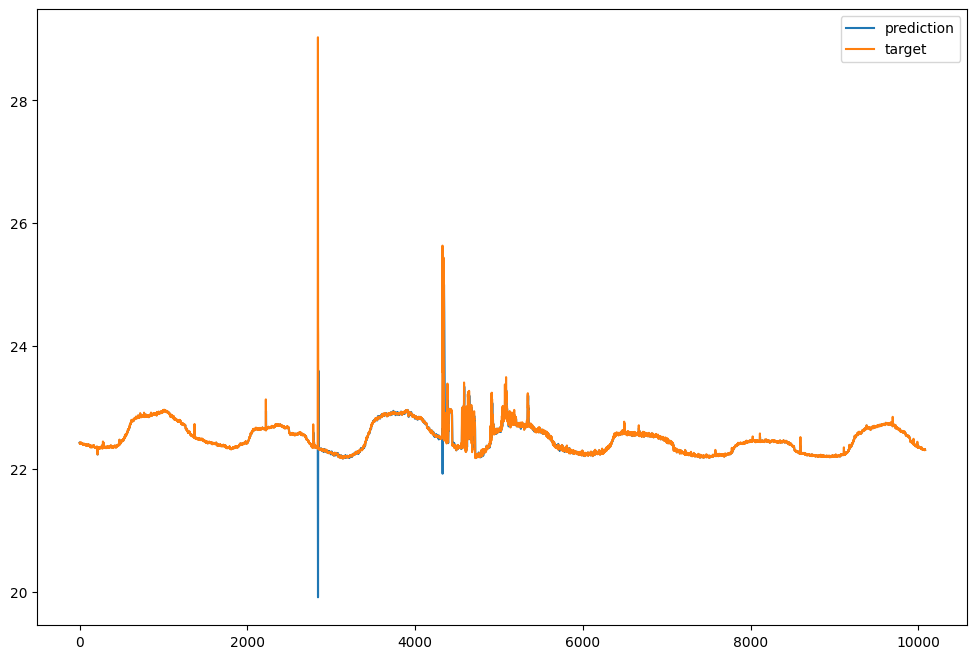

In [97]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [98]:
np.array(pred_list)

array([22.42740059, 22.4262352 , 22.41780663, ..., 22.30949593,
       22.31091881, 22.31136703])

In [99]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [100]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [101]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

0.10013624560087919 %


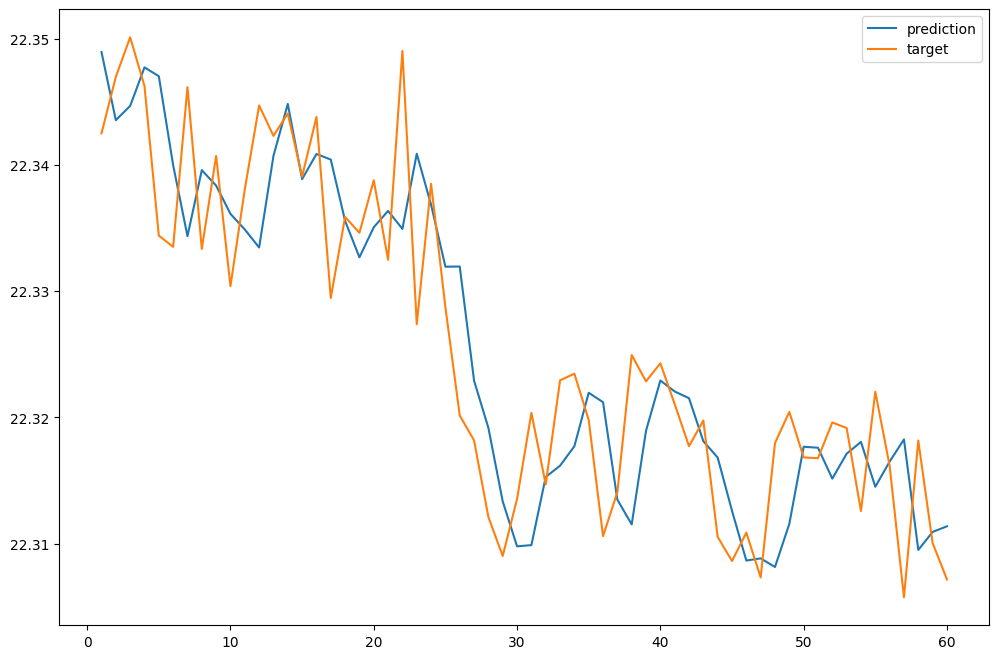

In [102]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [103]:
len(time_list)

10080

In [104]:
np.mean(time_list) 

0.31599229349503444